# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "C:/AV/Carla/CARLA_0.9.13/WindowsNoEditor/PythonAPI/experiments/logs"


In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
date = "2023-09-11-00-00"
fps=25
minYDisplacement = 5
maxXDisplacement = 9
df = pd.read_csv(os.path.join(dataDir, f"{date}-tracks.csv"))
df["uniqueTrackId"] = df["recordingId"] * 1000000 + df["trackId"]
pedDf = df[df["class"] == "pedestrian"].copy()
otherDf = df[df["class"] != "pedestrian"].copy()

## droping unnecessary states
pedDf = pedDf[(pedDf['state'] != "INITALIZING") & (pedDf['state'] != "FINISHED") & (pedDf['state'] != "CLIMBING_SIDEWALK")].copy()

print(pedDf.tail())

       recordingId  trackId       class  frame          x          y  \
64229          100      744  pedestrian    372 -75.991119  24.724771   
64230          100      744  pedestrian    373 -75.911682  24.734571   
64231          100      744  pedestrian    374 -75.832390  24.745762   
64232          100      744  pedestrian    375 -75.752945  24.755564   
64233          100      744  pedestrian    376 -75.673668  24.766752   

        heading     state  uniqueTrackId  
64229  9.823002  CROSSING      100000744  
64230  5.241670  CROSSING      100000744  
64231  9.823232  CROSSING      100000744  
64232  5.241873  CROSSING      100000744  
64233  9.823439  CROSSING      100000744  


In [6]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='x', 
        yCol='y',
        xVelCol='xVel', 
        yVelCol='yVel', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)

In [7]:
transformer.deriveAxisVelocities(pedDf)
transformer.deriveSpeed(pedDf)
transformer.smoothenSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# pedDf.describe()
pedDf.head()

,recordingId,trackId,class,frame,x,y,heading,state,uniqueTrackId,xVel,yVel,speed,speedSmooth,displacementX,displacementY
0,1,447,pedestrian,100,-82.606972,24.376476,-47.883739,CROSSING,1000447,-0.222206,0.134087,0.259528,0.254282,0.000000,0.000000
1,1,447,pedestrian,101,-82.598083,24.371113,-33.483780,CROSSING,1000447,-0.222206,0.134087,0.259528,0.236672,0.008888,0.005363
2,1,447,pedestrian,102,-82.594482,24.368587,-47.883739,CROSSING,1000447,-0.090027,0.063133,0.109957,0.203435,0.012489,0.007889
3,1,447,pedestrian,103,-82.585564,24.363159,-33.483780,CROSSING,1000447,-0.222969,0.135708,0.261021,0.188071,0.021408,0.013317
4,1,447,pedestrian,104,-82.581932,24.360569,-47.883739,CROSSING,1000447,-0.090790,0.064754,0.111517,0.186268,0.025040,0.015907


In [8]:
pedIds = pedDf["uniqueTrackId"].unique()

In [9]:
aPed = pedDf[pedDf["uniqueTrackId"] == pedIds[0]]
# plt.plot(aPed["yVel"], label='yVel')
# plt.plot(aPed["xVel"], label='xVel')
# plt.legend()
# sns.lineplot(aPed["speed"])
# sns.lineplot(aPed["speedSmooth"])

In [10]:
# smoothSpeed = aPed['speed'].rolling(10).mean()
# sns.lineplot(smoothSpeed, label='avg')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=1)
# sns.lineplot(smoothSpeed, label='gaussian1')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=2)
# sns.lineplot(smoothSpeed, label='gaussian2')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=3)
# sns.lineplot(smoothSpeed, label='gaussian3')

# Trajectory Stats & Visualizations

In [25]:
legend = False
limit = 10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


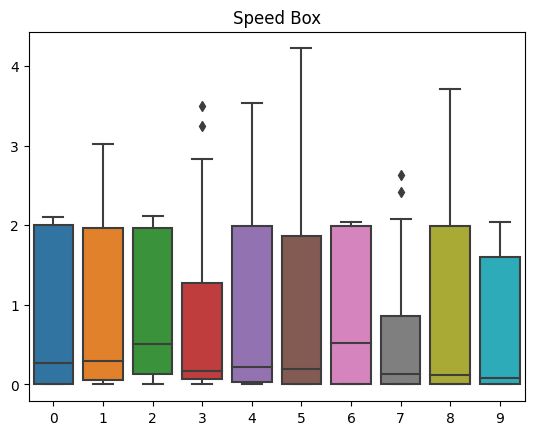

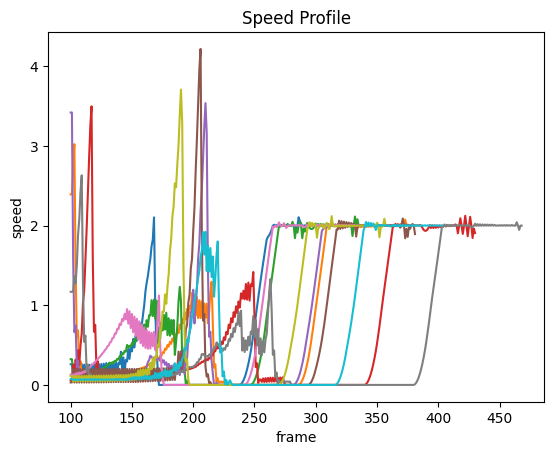

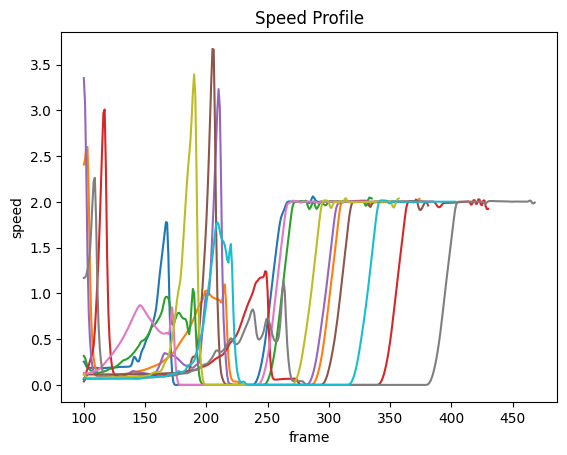

In [26]:
speedSeres = []
pedIds = pedDf["uniqueTrackId"].unique()
pedIds = pedIds[:limit]
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    speedSeres.append(aPed["speed"])
    # print("avg speed", aPed["speed"].mean())
    # print("max speed", aPed["speed"].max())
sns.boxplot(speedSeres)
plt.title("Speed Box")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

x = range(500)
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speed", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Speed Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Speed Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

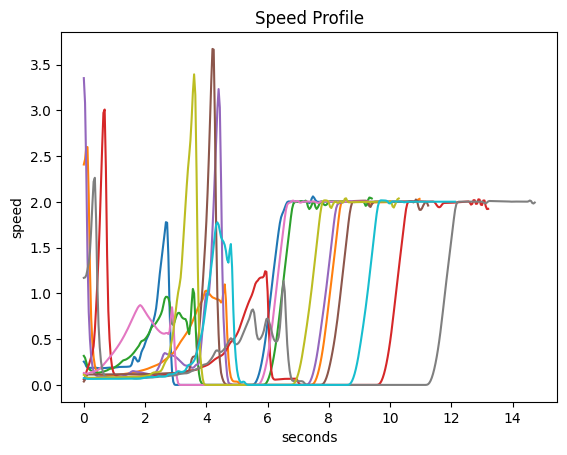

In [37]:
# visualization in seconds
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    # aPed = aPed.iloc[::int(fps//25), :] # frame rate is 25
    # seconds = (list(range(len(aPed))) + aPed.iloc[0]["frame"] / fps)
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("seconds")
plt.ylabel("speed")
plt.title("Speed Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()


# Frozen State Stats and Visualization

In [13]:
frozenPedDf = pedDf[pedDf['state'] == 'FROZEN'].copy()
pedIds = frozenPedDf["uniqueTrackId"].unique()

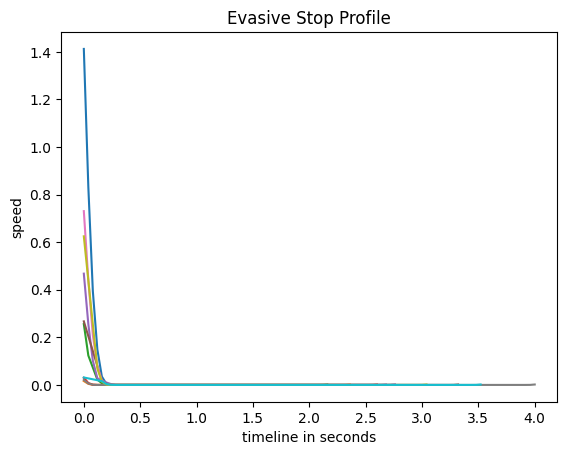

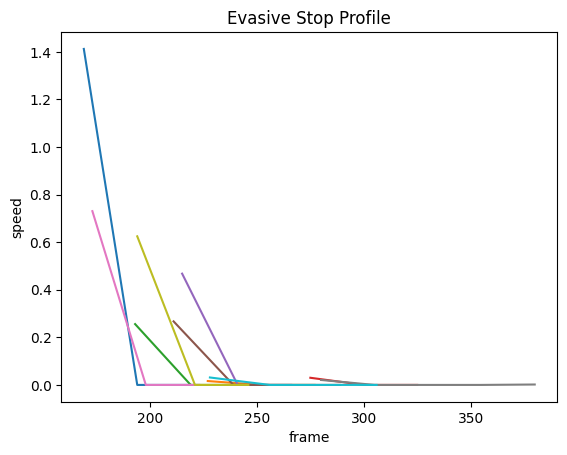

In [39]:
# visualization in seconds
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("timeline in seconds")
plt.ylabel("speed")
plt.title("Evasive Stop Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()
# visualization in frames
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    aPed = aPed.iloc[::int(fps), :] # frame rate is 25
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Evasive Stop Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

# Statistics

In [15]:
from collections import defaultdict

In [40]:
pedIds = pedDf["uniqueTrackId"].unique()
colData = defaultdict(lambda: list())
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    colData['uniqueTrackId'].append(pedId)
    colData['speed-avg'].append(aPed['speed'].mean())
    colData['speed-max'].append(aPed['speed'].max())
    colData['speed-min'].append(aPed['speed'].min())
    
    aPedFrozen = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    colData['stop-duration'].append(len(aPedFrozen) / fps)

pedStats = pd.DataFrame(colData)
pedStats.head()

,uniqueTrackId,speed-avg,speed-max,speed-min,stop-duration
0,1000447,0.814910,2.105765,0.0,2.80
1,2000450,0.758498,3.023658,0.0,2.40
2,3000453,0.817739,2.114786,0.0,2.16
3,4000456,0.669920,3.499209,0.0,2.64
4,5000459,0.752669,3.539347,0.0,2.68


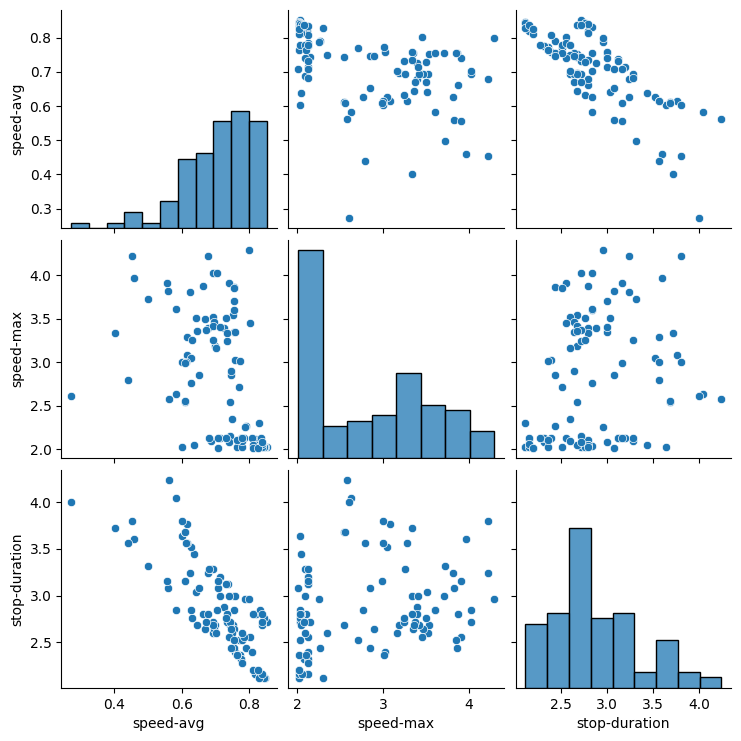

In [41]:
# Stop duration

sns.pairplot(pedStats[['speed-avg', 'speed-max', 'stop-duration']])

plt.xlabel("Correlations")
# plt.ylabel("speed")
# plt.title("Stop Duration")
plt.show()

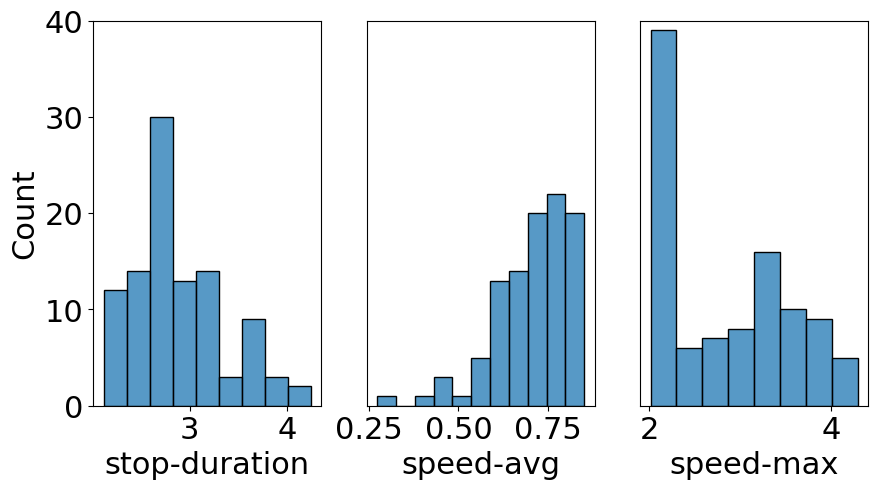

In [72]:
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1,3, figsize = (10,5))
sns.histplot(pedStats['stop-duration'] ,ax=axes[0])
axes[0].set_ylim(0, 40)
# plt.show()
sns.histplot(pedStats['speed-avg'] ,ax=axes[1])
axes[1].set_ylim(0, 40)
axes[1].get_yaxis().set_visible(False)

# plt.show()
sns.histplot(pedStats['speed-max'] ,ax=axes[2])
axes[2].set_ylim(0, 40)
axes[2].get_yaxis().set_visible(False)
# for ax in axes:
#     ax.set_ylim(50)
plt.show()

# Self joint probabilities

TypeError: __init__() got an unexpected keyword argument 'location'

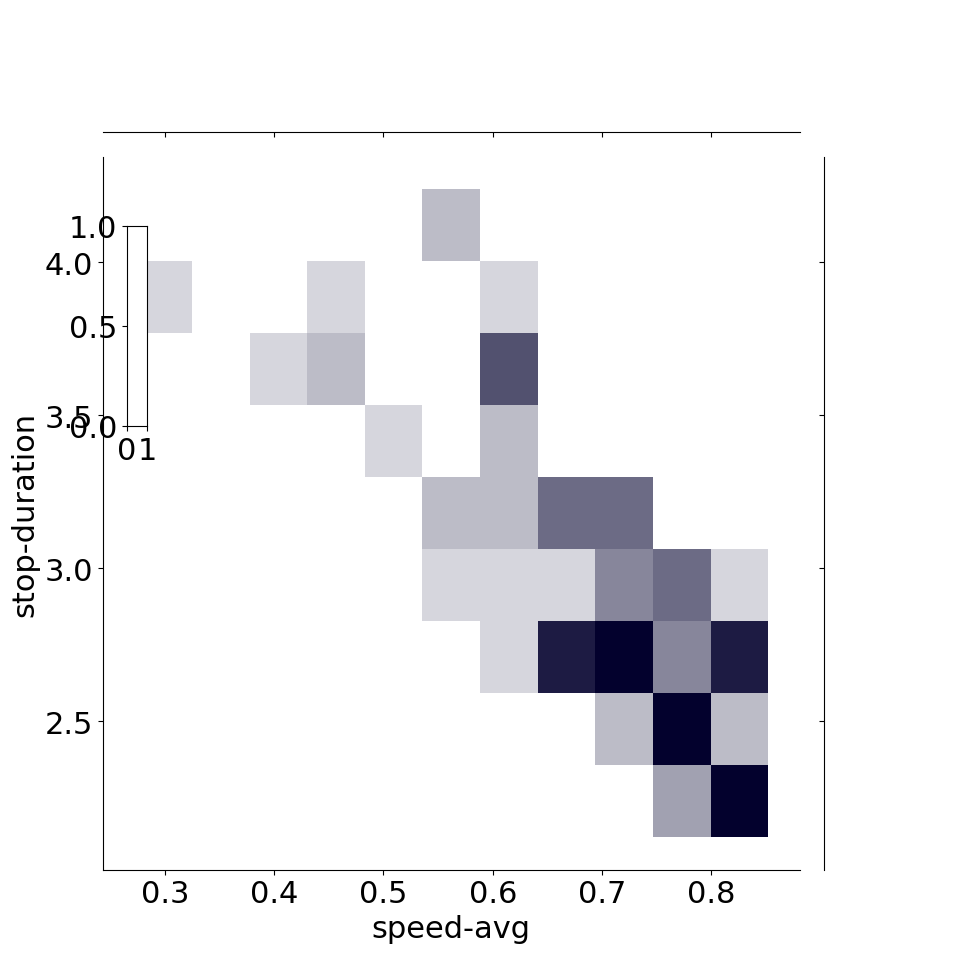

In [135]:
g = sns.JointGrid(data=pedStats, x="speed-avg", y="stop-duration", height=10)
# g.plot(sns.scatterplot, sns.histplot)

cax = g.figure.add_axes([.15, .55, .02, .2])
# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(False, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax, cbar_kws = {"location":"top"}
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

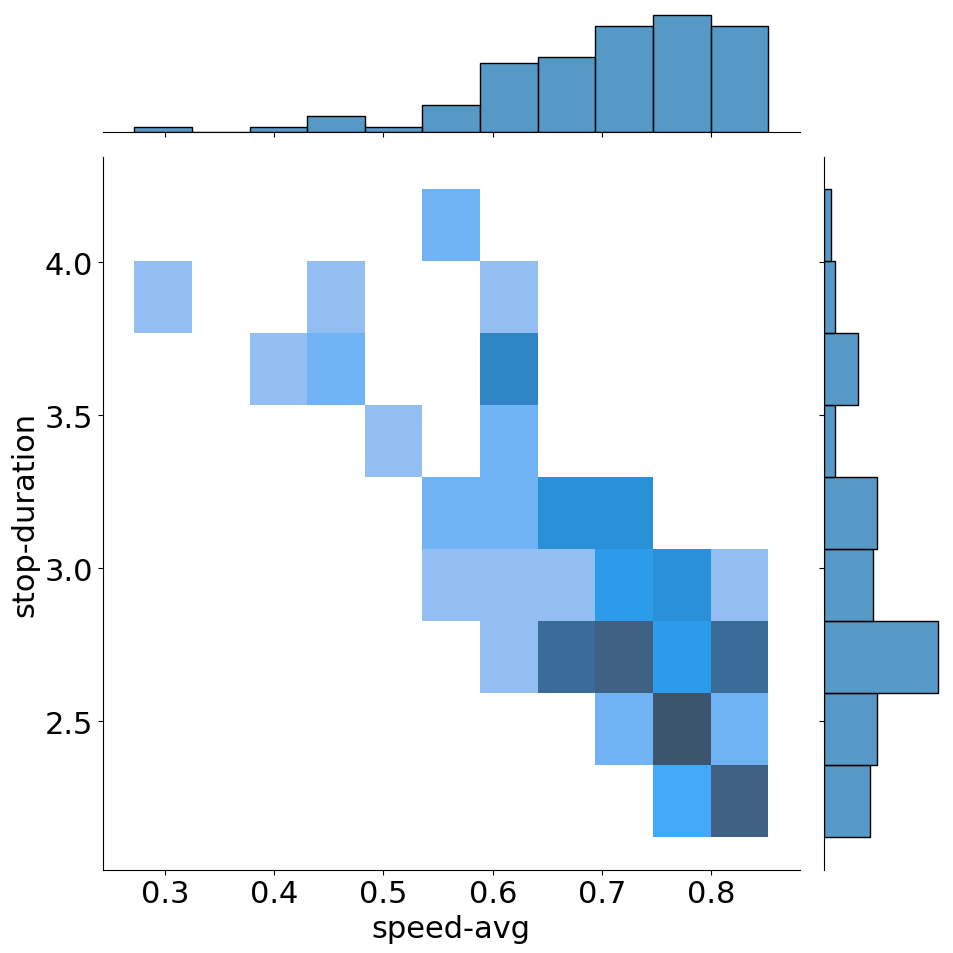

In [122]:
g = sns.jointplot(x=pedStats['speed-avg'], y=pedStats['stop-duration'], kind="hist", height=10)
# ax = g.ax_joint
# cbar_ax = kdeplot.fig.add_axes([.85, .25, .05, .4])
# # plt.colorbar(ax=ax, cax=cbar_ax)
# # plt.show()
# PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
# print(PCM)
# plt.colorbar(PCM, ax=ax, cax=cbar_ax) 


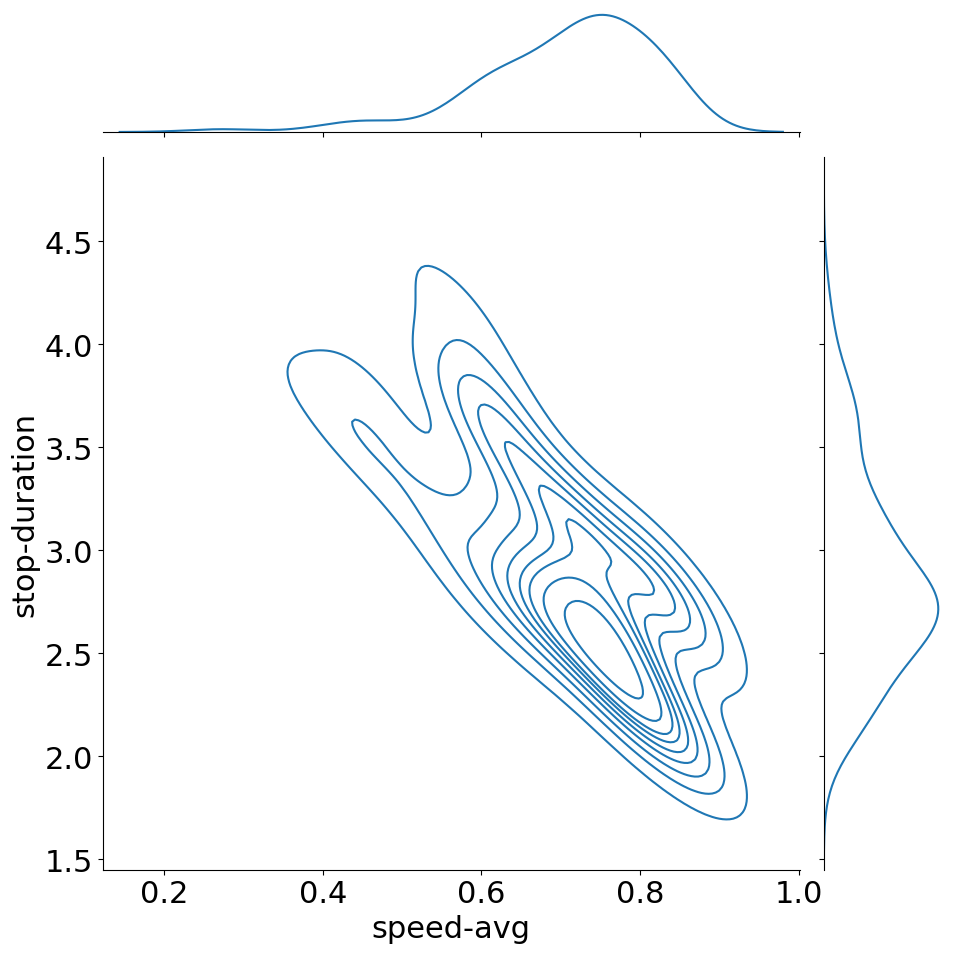

In [123]:
g = sns.jointplot(x=pedStats['speed-avg'], y=pedStats['stop-duration'], kind="kde", height=10)

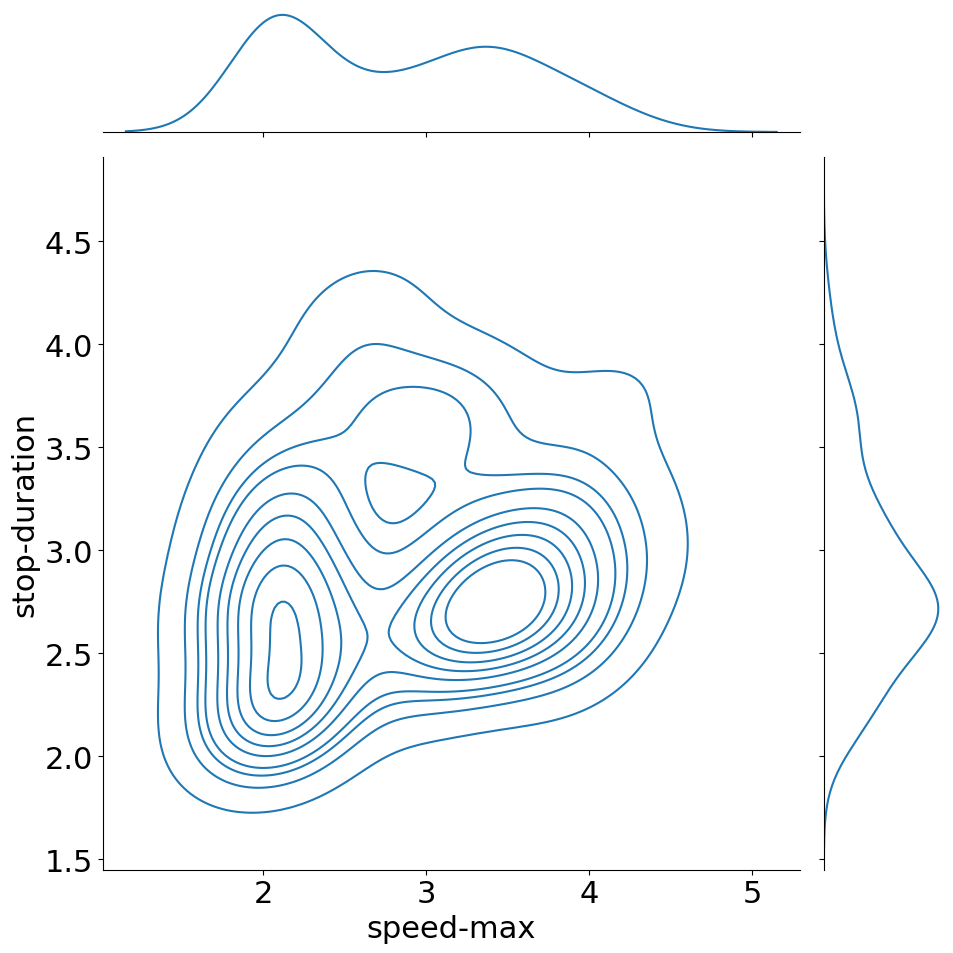

In [124]:
g = sns.jointplot(x=pedStats['speed-max'], y=pedStats['stop-duration'], kind="kde", height=10)

C:\Users\adhocmaster\AppData\Local\Temp\ipykernel_2904\686219070.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  flights = pedStats.pivot("speed-avg", "stop-duration")


<AxesSubplot: xlabel='None-stop-duration', ylabel='speed-avg'>

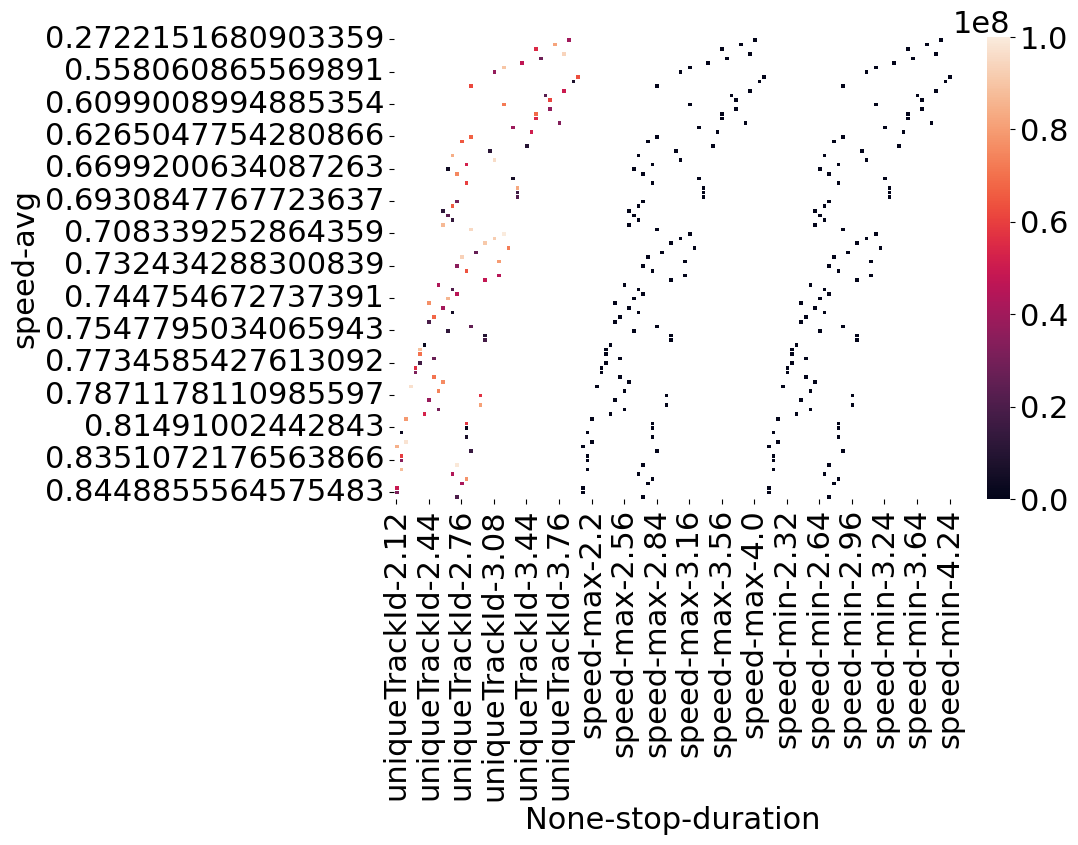

In [130]:
flights = pedStats.pivot("speed-avg", "stop-duration")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(flights, linewidths=.5, ax=ax)

# Vehicle joint plots

In [18]:
# 1. create ped vehicle map
# 2. vehicle speed vs ped speed
# 3. vehicle speed vs ped stop duration
# 4. vehicle speed vs ped stop location